In [31]:
#generic import and constant definition list
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py
import astropy.constants as cons
from matplotlib.colors import LogNorm
import astropy.units as u
import pandas as pd
import scipy.optimize as opt
#all of the important fundamental constants are put into cgs units just for convenience
c=cons.c.cgs.value
G=cons.G.cgs.value
h=cons.h.cgs.value
hbar=cons.hbar.cgs.value
Msun=cons.M_sun.cgs.value
Rsun=cons.R_sun.cgs.value
Rearth=cons.R_earth.cgs.value
mp=cons.m_p.cgs.value
me=cons.m_e.cgs.value
mn=cons.m_n.cgs.value
kB=cons.k_B.cgs.value
mu_e=2 #mean mass per electron for He-core or C/O core composition
m_u = 1/cons.N_A.cgs.value #atomic mass unit in grams

$$ m - M = 5\log_{10}(\frac{d_L}{M_{pc}}) + 25 $$

$$d_L \approx cH_0^{-1} \left( z + 1/2(1-q_0)z^2\right) $$




We want to perform least-squares so we should make this all into a matrix,


$$
\begin{pmatrix}
  \Sigma \frac{x_i^2}{\sigma_i^2} & \Sigma \frac{x_i}{\sigma_i^2}\\
  \Sigma \frac{x_i}{\sigma_i^2} & \Sigma \frac{1}{\sigma_i^2}\\
\end{pmatrix}
\begin{pmatrix}
  a \\
  b \\
\end{pmatrix}
=
\begin{pmatrix}
  \Sigma \frac{d_i x_i}{\sigma_i^2} \\
  \Sigma \frac{d_i}{\sigma_i^2} \\
\end{pmatrix}
$$




where a and b have the relationship 

$$
m-M = a \log_{10}(z) + b
$$


To find a and b then the code goes through and basically just treats it as a matrix inversion problem with 

$$
\begin{pmatrix}
  a \\
  b \\
\end{pmatrix} = \left( \begin{pmatrix}
  \Sigma \frac{x_i^2}{\sigma_i^2} & \Sigma \frac{x_i}{\sigma_i^2}\\
  \Sigma \frac{x_i}{\sigma_i^2} & \Sigma \frac{1}{\sigma_i^2}\\
\end{pmatrix}\right)^{-1} \begin{pmatrix}
  \Sigma \frac{d_i x_i}{\sigma_i^2} \\
  \Sigma \frac{d_i}{\sigma_i^2} \\
\end{pmatrix}
$$

$$
\left(\frac{cH_0^{-1} \left( z + 1/2(1-q_0)z^2\right) }{M_{pc}}\right)^5(10^{25}) = 10^{a\log_{10}(z) + b} 


$$

$$
\left(\frac{cH_0^{-1}}{M_{pc}}\right)^5(10^{25}) = 10^{b} \Rightarrow H_0 = \left(\frac{10^{25}}{10^b}\right)^{1/5}\frac{c}{M_{pc}}

$$

$$
z^a =\left( z + 1/2(1-q_0)z^2\right)^5 \Rightarrow  q_0= -2(z^{a/5} -z)z^{-2} +1
$$

In [33]:
data = pd.read_csv('supernovae_data.txt',header=None,delimiter='\t',names=['name','z','m-M', 'error','NA'])
print(data.head())

     name         z        m-M     error        NA
0  1993ah  0.028488  35.346583  0.223906  0.128419
1  1993ag  0.050043  36.682368  0.166829  0.128419
2   1993o  0.052926  36.817691  0.155756  0.128419
3   1993b  0.070086  37.446737  0.158467  0.128419
4  1992bs  0.062668  37.483409  0.156099  0.128419


## Using a linear least squares approach with np.linalg.lstsq to fit the data

In [34]:
M = np.vstack([np.log10(data['z']),np.ones(len(data['z']))]).T
results = np.linalg.lstsq(M,data['m-M'],rcond=None)

In [35]:
a,b = results[0] #gives the slope and intercept of the best fit line

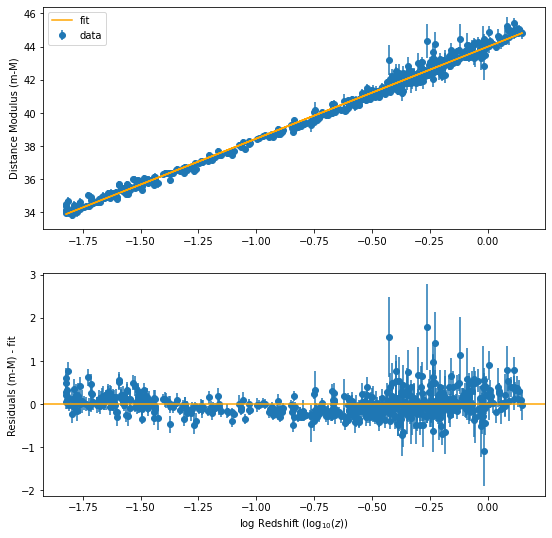

In [36]:
fig,ax = plt.subplots(2,1,figsize=(9,9))
ax[0].errorbar(np.log10(data['z']),data['m-M'],data['error'],fmt='o',label='data',zorder=1)
predicted = a*np.log10(data['z']) + b

ax[0].plot(np.log10(data['z']),predicted,color='orange',label='fit')
ax[0].set_ylabel('Distance Modulus (m-M)')
ax[0].legend()
ax[1].errorbar(np.log10(data['z']),data['m-M']-predicted,data['error'],fmt='o',label='data - fit',zorder=1)
ax[1].axhline(0,color='orange')
ax[1].set_xlabel('log Redshift ($\log_{10}(z)$)')
ax[1].set_ylabel('Residuals (m-M) - fit')
plt.show()

In [37]:
q_0 = -2*(data['z']**(a/5)-data['z'])*(data['z']**(-2)) + 1

In [38]:
c = cons.c.cgs.value*1e-5 #speed of light in km/s

In [39]:
h_0 = (((10**25)/(10**b))**(1/5))*c

In [40]:
print("Estimated value of deceleration parameter q_0:",np.mean(q_0),"+/-",np.std(q_0))

Estimated value of deceleration parameter q_0: 8.40309818414453 +/- 12.197782035590482


In [41]:
print('The value of H_0 is', h_0, 'km/s/Mpc')

The value of H_0 is 47.744435147998104 km/s/Mpc


## I also did a weighted least squares version to see if I could get a better answer for $q_0$ and I can't but here it is 

In [42]:
import statsmodels.api as sm

In [ ]:
M = np.vstack([np.log10(data['z']),np.ones(len(data['z']))]).T

weights = 1/(data['error']**2)
model = sm.WLS(data['m-M'], M, weights=weights)
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                    m-M   R-squared:                       0.995
Model:                            WLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.189e+05
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:29:14   Log-Likelihood:                 33.296
No. Observations:                 580   AIC:                            -62.59
Df Residuals:                     578   BIC:                            -53.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             5.4907      0.016    344.812      0.0

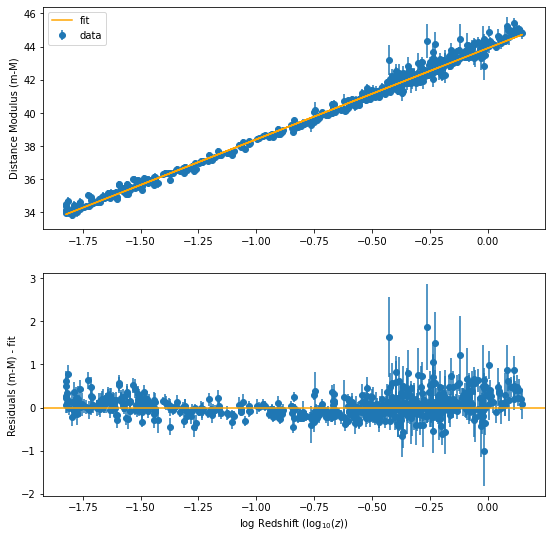

In [44]:
a= 5.4907
b= 43.9001
fig,ax = plt.subplots(2,1,figsize=(9,9))
ax[0].errorbar(np.log10(data['z']),data['m-M'],data['error'],fmt='o',label='data',zorder=1)
predicted = a*np.log10(data['z']) + b

ax[0].plot(np.log10(data['z']),predicted,color='orange',label='fit')
ax[0].set_ylabel('Distance Modulus (m-M)')
ax[0].legend()
ax[1].errorbar(np.log10(data['z']),data['m-M']-predicted,data['error'],fmt='o',label='data - fit',zorder=1)
ax[1].axhline(0,color='orange')
ax[1].set_xlabel('log Redshift ($\log_{10}(z)$)')
ax[1].set_ylabel('Residuals (m-M) - fit')
plt.show()

In [46]:
c = cons.c.cgs.value*1e-5 #speed of light in km/s
h_0 = (((10**25)/(10**b))**(1/5))*c
q_0 = -2*(data['z']**(a/5)-data['z'])*(data['z']**(-2)) + 1
print('The value of H_0 is', h_0, 'km/s/Mpc')
print("Estimated value of deceleration parameter q_0:",np.mean(q_0),"+/-",np.std(q_0))

The value of H_0 is 49.750872659421816 km/s/Mpc
Estimated value of deceleration parameter q_0: 7.904009283376691 +/- 11.393009784743334
